# 单发多框检测SSD

这里我们来学习李沐d2l中的单发多框检测SSD，这是一个非常经典的目标检测算法，我们将在这里学习它的原理和实现。

下面是该网络的总架构图：

<center><img src="image/SSD.png" width=600></center>

> - 注意到上面的图中为了便于理解，我们并没有将每一个predictor的输出进行连接起来。
> - 实际上在训练网络的时候是需要连接起来更好计算损失函数等操作的。
>

在上面的图中的`base_net`在d2l中称为基础网络块，而多尺度特征块中我们直接用`down_sample_blk`来表示，而`predictor`则是我们的预测网络块，其中又分为`cls_predictor`和`bbox_predictor`，分别用于预测类别和边界框。

## 导入库

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from utils.bbox import *
from utils.data import *
from utils.device import try_gpu

## 定义模型

### 预测网络块

#### 类别预测层

In [2]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    """
    类别预测层
    @param num_inputs: 输入通道数
    @param num_anchors: 每个像素点的锚框数量
    @param num_classes: 类别数量
    @return: 类别预测层
    @note: 该层输出形状为(批量大小, num_anchors * (num_classes + 1), 高, 宽)
    """
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

#### 边界框预测层

In [3]:
def bbox_predictor(num_inputs, num_anchors):
    """
    边界框预测层
    @param num_inputs: 输入通道数
    @param num_anchors: 每个像素点的锚框数量
    @return: 边界框预测层
    @note: 该层输出形状为(批量大小, num_anchors * 4, 高, 宽)
    """
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

#### 展平连接预测输出

In [5]:
def flatten_pred(pred):
    """
    将预测结果变换成二维数组
    @param pred: 输出
    @return: 二维数组
    @note: (批量大小, 通道数, 高, 宽) -> (批量大小, 高, 宽, 通道数) -> (批量大小, 高 * 宽 * 通道数)
    """
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    """
    将多尺度的预测结果拼接
    @param preds: 预测结果列表
    @return: 拼接后的预测结果
    @note: preds中的每个元素形状为(批量大小, \sum_i{height_i * width_i * channels_i})
    """
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [6]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### 下采样块

In [7]:
def down_sample_blk(in_channels, out_channels):
    """
    下采样模块：两个卷积层和一个最大池化层，功能是将输入特征图的高和宽减半
    @param in_channels: 输入通道数
    @param out_channels: 输出通道数
    @return: 下采样模块
    @note: 该模块输出形状为(批量大小, out_channels, 高 / 2, 宽 / 2)
    """
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [8]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### 基础网络块

In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 构建块

In [10]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    """
    一个块的前向传播
    @param X: 输入
    @param blk: 块
    @param size: 缩放比例列表
    @param ratio: 长宽比列表
    @param cls_predictor: 类别预测层
    @param bbox_predictor: 边界框预测层
    @return: 块的输出
    @note: 块的输出包括特征图、锚框、类别预测和边界框预测，
    
    - 其中特征图Y形状为(批量大小, 通道数, 高, 宽)，
    - 锚框形状为(1, 高 * 宽 * num_anchors, 4)，
    - 类别预测形状为(批量大小, num_anchors*(num_classes + 1), 高, 宽)，
    - 边界框预测形状为(批量大小, num_anchors*4, 高, 宽)
    """
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [12]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

### TinySSD

In [13]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, sizes, ratios, **kwargs):
        """
        TinySSD模型
        @param num_classes: 类别数
        @param sizes: 缩放比例列表
        @param ratios: 长宽比列表
        @param kwargs: 其他参数
        """
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        """
        前向传播
        @param X: 输入
        @return: 输出
        @note: 输出包括锚框、类别预测和边界框预测，
        - `anchors`形状为(批量大小, num_anchors, 4)
        - `cls_preds`形状为(批量大小, num_anchors, (num_classes + 1))
        - `bbox_preds`形状为(批量大小, num_anchors*4)
        """
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [14]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## 训练模型

### 加载数据集和初始化

In [15]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [16]:
device, net = try_gpu(), TinySSD(num_classes=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### 定义损失函数和评价函数

对于类别，这是一个分类问题，我们肯定使用交叉熵损失函数，如下：

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
          l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
          \cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}
$$

对于边界框，这是一个回归问题，但我们没有使用squared loss，而是使用了L1loss，如下：

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = \left| x_n - y_n \right|,
$$

In [17]:
cls_loss = nn.CrossEntropyLoss(reduction='none') # 设置为none的意思是不对损失求平均
bbox_loss = nn.L1Loss(reduction='none') # 同上，是一个向量，每个元素是一个样本的损失

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    """
    计算损失
    @param cls_preds: 类别预测
    @param cls_labels: 类别标签
    @param bbox_preds: 边界框预测
    @param bbox_labels: 边界框标签
    @param bbox_masks: 边界框掩码
    @return: 损失
    @note: 损失包括类别损失和边界框损失
    """
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [18]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    # （cls_preds的维度是（批量大小，锚框总个数，类别数）
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### 开始训练

class err 3.17e-03, bbox mae 3.13e-03
1802.9 examples/sec on cpu


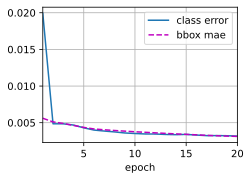

In [19]:
from utils.show import Animator
from utils.tools import Timer, Accumulator
num_epochs, timer = 20, Timer()
animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        optimizer.zero_grad()
        X, Y = features.to(device), target.to(device)

        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)

        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        
        l.mean().backward()

        optimizer.step()
        metric.add(
            cls_eval(cls_preds, cls_labels), 
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
        
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

    animator.add(epoch + 1, (cls_err, bbox_mae))

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

### 预测目标

我们将对下面图片进行预测🍌的位置

![banana](image/test.jpg)

In [70]:
X = torchvision.io.read_image('./image/test.jpg').unsqueeze(0).float()
X.shape

torch.Size([1, 3, 256, 256])

In [71]:
# 将X的宽高缩放到256
img = torchvision.transforms.Resize((256, 256))(X)
img.shape

torch.Size([1, 3, 256, 256])

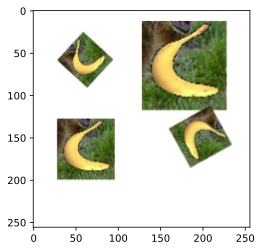

In [72]:
# 显示img
plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8))
plt.show()

In [73]:
img = img.squeeze(0).permute(1, 2, 0).long()
img.shape

torch.Size([256, 256, 3])

In [74]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1) # 利用softmax转换成概率
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

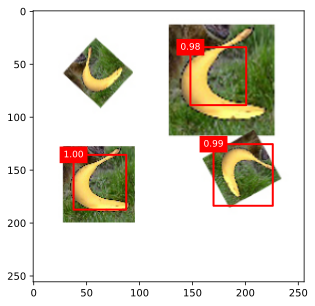

In [76]:
def display(img, output, threshold):
    plt.figure(figsize=(5, 5))
    fig = plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')

display(img, output.cpu(), threshold=0.9)